# **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from tqdm import tqdm
seed = 123
import cv2
import xml.etree.ElementTree as ET
torch.manual_seed(seed)
from collections import Counter

# **Model Architecture**

In [2]:
architecture_config = [
    #Tuple: (kernel_size, number of filters, strides, padding)
    (7, 64, 2, 3),
    #"M" = Max Pool Layer
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    #List: [(tuple), (tuple), how many times to repeat]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    #Doesnt include fc layers
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))
    
class YoloV1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
        
    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])]
                in_channels = x[1]
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif type(x) == list:
                conv1 = x[0] #Tuple
                conv2 = x[1] #Tuple
                repeats = x[2] #Int
                
                for _ in range(repeats):
                    layers += [CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3])]
                    layers += [CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])]
                    in_channels = conv2[1]
                    
        return nn.Sequential(*layers)
    
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(nn.Flatten(), nn.Linear(1024 * S * S, 496), nn.Dropout(0.0), nn.LeakyReLU(0.1), nn.Linear(496, S * S * (C + B * 5)))#Original paper uses nn.Linear(1024 * S * S, 4096) not 496. Also the last layer will be reshaped to (S, S, 13) where C+B*5 = 13

# **Utility Functions**

# **Intersection Over Union**

In [4]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x,y,w,h) or (x1,y1,x2,y2) respectively.
    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)
    
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] # Output tensor should be (N, 1). If we only use 3, we go to (N)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

# Sample Input to the functions

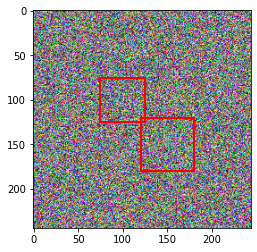

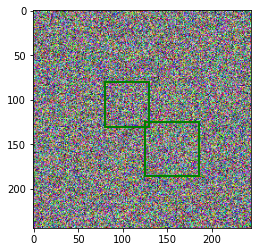

Intersection over Union (IoU): tensor([[0.6807],
        [0.7246]])


In [5]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Generate a random image (3 channels, height 244, width 244)
image = torch.rand(3, 244, 244)

# Sample bounding boxes in the 'midpoint' format (x_center, y_center, width, height)
boxes_preds = torch.tensor([[100, 100, 50, 50], [150, 150, 60, 60]], dtype=torch.float32)
boxes_labels = torch.tensor([[105, 105, 50, 50], [155, 155, 60, 60]], dtype=torch.float32)

# Function to draw bounding boxes on the image
def draw_boxes(image, boxes, color='r'):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    
    for box in boxes:
        x_center, y_center, width, height = box
        x = x_center - width / 2
        y = y_center - height / 2
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

# Draw the bounding boxes
draw_boxes(image, boxes_preds, color='r')  # Red for predictions
draw_boxes(image, boxes_labels, color='g')  # Green for labels

# Calculate IoU
iou = intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint')
print("Intersection over Union (IoU):", iou)


# **Non-Max Supression**

In [6]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

# Sample input to NMS

Bounding boxes after NMS: [[0, 0.9, 30, 40, 150, 200], [1, 0.75, 100, 120, 200, 220]]
Original bounding boxes:


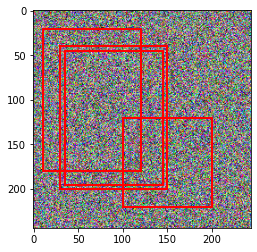

Bounding boxes after NMS:


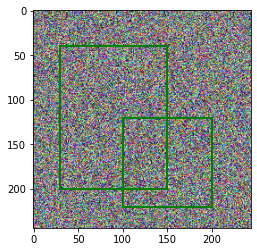

In [7]:
# Generate a random image (3 channels, height 244, width 244)
image = torch.rand(3, 244, 244)

# Sample bounding boxes in the 'corners' format (class_pred, prob_score, x1, y1, x2, y2)
bboxes = [
    [0, 0.9, 30, 40, 150, 200],  # Class 0, High confidence
    [0, 0.85, 35, 45, 145, 195],  # Class 0, Slightly shifted
    [1, 0.75, 100, 120, 200, 220],  # Class 1
    [0, 0.6, 10, 20, 120, 180],  # Class 0, Lower confidence
]

iou_threshold = 0.5
threshold = 0.6

# Apply Non-Max Suppression
bboxes_after_nms = non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners")
print("Bounding boxes after NMS:", bboxes_after_nms)

# Function to draw bounding boxes on the image
def draw_boxes(image, bboxes, color='r'):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    
    for box in bboxes:
        _, _, x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

# Draw the original bounding boxes
print("Original bounding boxes:")
draw_boxes(image, bboxes, color='r')

# Draw the bounding boxes after NMS
print("Bounding boxes after NMS:")
draw_boxes(image, bboxes_after_nms, color='g')

# **Mean Average Precision**

In [8]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

# **Last Utility Functions**

In [10]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7, C=3):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

# **Dataset Preprocessing**

In [11]:
files_dir = '../input/fruit-images-for-object-detection/train_zip/train'
test_dir = '../input/fruit-images-for-object-detection/test_zip/test'

images = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
annots = []
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)
    
images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)
df = pd.DataFrame(df)

test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)
test_df = pd.DataFrame(test_df)

In [12]:
class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df=df, files_dir=files_dir, S=7, B=2, C=3, transform=None):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()
        
        class_dictionary = {'apple':0, 'banana':1, 'orange':2}
    
        if(int(root.find('size').find('height').text) == 0):
            filename = root.find('filename').text
            img = Image.open(self.files_dir + '/' + filename)
            img_width, img_height = img.size
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])
            
        elif(int(root.find('size').find('height').text) != 0):
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])

                
        boxes = torch.tensor(boxes)
        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
#             print(i, j)
            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix


# **Model Loss**

In [14]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

# **Model Training**

In [15]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [16]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

In [17]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [18]:
def main():
    model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = FruitImagesDataset(
        transform=transform,
        files_dir=files_dir
    )

    test_dataset = FruitImagesDataset(
        transform=transform, 
        files_dir=test_dir
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn)
        
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        
        scheduler.step(mean_avg_prec)
    
    checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
    



if __name__ == "__main__":
    main()

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 15/15 [00:14<00:00,  1.05it/s, loss=322]   


Mean loss was 647.1437154134114


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.0


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=314]


Mean loss was 323.43690388997396


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 6.010682773194276e-05


100%|██████████| 15/15 [00:10<00:00,  1.47it/s, loss=239]


Mean loss was 222.55359293619793


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.0225870031863451


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=204]


Mean loss was 171.63694407145184


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.06746798753738403


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=83] 


Mean loss was 131.0957804361979


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.08493480831384659


100%|██████████| 15/15 [00:10<00:00,  1.47it/s, loss=95.6]


Mean loss was 106.1280293782552


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.1699208766222


100%|██████████| 15/15 [00:10<00:00,  1.43it/s, loss=66.7]


Mean loss was 91.8670420328776


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.22895120084285736


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=66.3]


Mean loss was 79.24523264567057


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.29361340403556824


100%|██████████| 15/15 [00:10<00:00,  1.44it/s, loss=82.5]


Mean loss was 73.40945281982422


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.3507573902606964


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=76.7]


Mean loss was 69.1218032836914


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.3786376416683197


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=61.9]


Mean loss was 65.63438161214192


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.46782946586608887


100%|██████████| 15/15 [00:10<00:00,  1.46it/s, loss=55.7]


Mean loss was 62.22925593058268


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.5441998839378357


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=53.2]


Mean loss was 53.27093556722005


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.6562845706939697


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=49.1]


Mean loss was 51.02394053141276


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.7086750864982605


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=53.9]


Mean loss was 52.31942342122396


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.7386192679405212


100%|██████████| 15/15 [00:10<00:00,  1.43it/s, loss=42.5]


Mean loss was 46.825032552083336


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.7598702311515808


100%|██████████| 15/15 [00:10<00:00,  1.46it/s, loss=44.8]


Mean loss was 44.895379638671876


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.7965965867042542


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=39.2]


Mean loss was 42.68747177124023


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.8405055403709412


100%|██████████| 15/15 [00:10<00:00,  1.46it/s, loss=43.7]


Mean loss was 43.87110837300619


  0%|          | 0/15 [00:00<?, ?it/s]

Train mAP: 0.8505577445030212


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=36.3]


Mean loss was 38.22578887939453
Train mAP: 0.8748166561126709
=> Saving checkpoint


Thanks for reading! If you found this helpful, feel free to upvote. 